In [12]:
from glob import glob
import numpy as np
import cv2
from gi.repository import Vips
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

import sys
xfeatures2d = sys.modules['cv2.xfeatures2d']
SURF = xfeatures2d.SURF_create

In [2]:
def imshow(img):
    if len(img.shape) == 2 or img.shape[2] == 1:
        img = np.dstack([img, img, img])
    b, g, r = cv2.split(img)
    rgb_img = cv2.merge([r, g, b])
    plt.imshow(rgb_img)
    plt.show()

In [51]:
def read_vips(filename):
    return Vips.Image.new_from_file(filename)

def extract_gray(image, offset_x, offset_y, size_x=1024, size_y=1024):
    subimage = image.extract_area(offset_x, offset_y, size_x, size_y)
    mat = np.fromstring(subimage.write_to_memory(), dtype=np.int16)
    return np.uint8(mat.reshape(size_y, size_x) / 8)

def extract_bgr(image, offset_x, offset_y, size_x=1024, size_y=1024):
    subimage = image.extract_area(offset_x, offset_y, size_x, size_y)
    channels = [1, 2, 4]
    mat = np.fromstring(subimage.write_to_memory(), dtype=np.int16)
    return np.uint8(mat.reshape(size_y, size_x, 8) / 8)[:, :, channels]
    
def rescale_bands(image):
    scaled_image = np.zeros(image.shape, dtype=np.float)
    q = (2, 98)
    for i in range(3):
        p1, p2 = np.percentile(image[:, :, i], q)
        print(i, p1, p2)
#         p1, p2 = [(32, 128), (32, 192), (16, 168)][i]
        scaled_image[:, :, i] = np.clip((image[:, :, i] - p1) / (p2 - p1) * 256, 0, 255)
    return np.uint8(scaled_image)

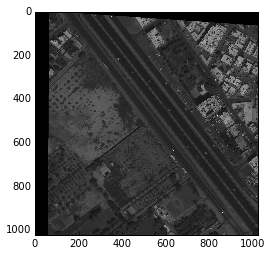

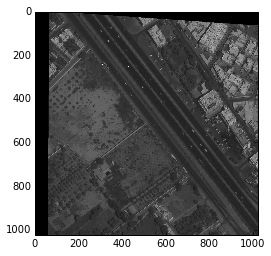

In [52]:
dir_path = "../hackday/tmp/"
files = sorted(glob(dir_path + '*.TIF'))

img0 = read_vips(files[0])
img0 = extract_gray(img0, 0, 0)
imshow(img0)

img1 = read_vips(files[1])
img1 = extract_gray(img1, 0, 0)
imshow(img1)

In [53]:
def norm(ps):
    ps = ps.reshape(-1, 2)
    return np.sum(ps ** 2, axis=-1) ** 0.5

In [54]:
def checked_flow(gray_img0, gray_img1, p0, max_err=1.0, win_size=15, max_level=3):
    lk_params = dict(winSize=(win_size, win_size),
                     maxLevel=max_level,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 20, 0.1))
    h, w = gray_img0.shape[:2]
    p0 = p0 * w
    p_idx = np.arange(len(p0))

    p1, _, _ = cv2.calcOpticalFlowPyrLK(gray_img0, gray_img1, p0, None, **lk_params)
    p0r, _, _ = cv2.calcOpticalFlowPyrLK(gray_img1, gray_img0, p1, None, **lk_params)
    err = norm(p0-p0r).ravel()
    good = err < max_err
    p1, p_idx, err = p1.reshape(-1, 2)[good], p_idx[good], err[good]
    return p1/w, p_idx, err

In [55]:
def to_int_tuple(p, w):
    return (int(p[0]*w), int(p[1]*w))

In [56]:
def homogenize(a, w=1.0):
    o = np.zeros((len(a), 1), a.dtype)
    o[:] = w
    return np.hstack([a, o])

In [57]:
def homo_translate(matrix, points):
    points = np.atleast_2d(points)
    if points.shape[-1] < matrix.shape[1]:
        points = homogenize(points)
    p = np.dot(points, matrix.T)
    return p[:, :-1] / p[:, -1, np.newaxis]

In [58]:
def get_extension(H, shape):
    corners = np.array([[0.0, 0.0, 1.0], [shape[0], 0.0, 1.0], [0.0, shape[1], 1.0], [shape[0], shape[1], 1.0]])
    new_corners = []
    for p in corners:
        tmp = H.dot(p)
        new_corners.append(tmp[:2] / tmp[2])
    new_corners = np.array(new_corners)
    minx, maxx, miny, maxy = np.min(new_corners[:, 0]), np.max(new_corners[:, 0]), \
            np.min(new_corners[:, 1]), np.max(new_corners[:, 1])
    return -minx, -miny, (int(maxx - minx), int(maxy - miny))

def get_translation_matrix(dx,dy):
    return  np.array([[1.0, 0.0, dx], [0.0, 1.0, dy], [0.0, 0.0, 1.0]])
    
#     Htrans = np.array([[1.0, 0.0, -minx], [0.0, 1.0, -miny], [0.0, 0.0, 1.0]])
#     new_H = np.dot(Htrans, H)
#     new_shape = (int(maxx - minx), int(maxy - miny))
#     return new_H, new_shape

In [80]:
_INVALID_DISPARITY = np.iinfo(np.int16).max

def calc_disparity(img0, img1, disparity_range, P1=40, P2=400, invalid_disparity=_INVALID_DISPARITY):
    window_size = 3
    disparity_granulate = 16
    disparity_min, disparity_max = disparity_range
    disparity_min = int(disparity_min // disparity_granulate * disparity_granulate)
    disparity_max = int((disparity_max + disparity_granulate - 1) // disparity_granulate * disparity_granulate)
    stereo = cv2.StereoSGBM_create(minDisparity=disparity_min, 
                                   numDisparities=disparity_max - disparity_min + disparity_granulate,
                                   blockSize=window_size,
                                   uniquenessRatio=15,
                                   speckleWindowSize=100,
                                   speckleRange=2,
                                   disp12MaxDiff=1,
                                   P1=P1*window_size**2,
                                   P2=P2*window_size**2,
                                   preFilterCap=100)

    disparity = stereo.compute(img0, img1)
    global gl_invalid
    invalid = (disparity == disparity.min())
    gl_invalid = invalid
    global image0
    image0 = img0
    global image1
    image1 = img1
    invalid |= (img0 == 0) | (img1 == 0)
    disparity[invalid] = invalid_disparity
    if invalid_disparity == _INVALID_DISPARITY:
        assert disparity.dtype == np.int16
    valid_mask = (disparity != invalid_disparity)
    disparity = disparity / disparity_granulate
    return disparity, valid_mask

In [105]:
import numpy as np
import pyopencl as cl
import pyopencl.array

primal_dual_kernels = '''
#line 20

#define read(img)           img[coord.y * work_size.x + coord.x]
#define read_dxy(img, dxy)  img[(coord.y + dxy.y) * work_size.x + (coord.x + dxy.x)]
#define write(img, value)   img[coord.y * work_size.x + coord.x] = value

#define read3d(img, layer)         img[layer*(work_size.y*work_size.x) + coord.y*(work_size.x) + coord.x]
#define write3d(img, layer, value) img[layer*(work_size.y*work_size.x) + coord.y*(work_size.x) + coord.x]=value

__constant int2 dx = (int2) (1, 0);
__constant int2 dy = (int2) (0, 1);

float sum(float2 v) {
    return v.x + v.y;
}

float project(float v, float r) {
    return clamp(v, -r, r);
}

float2 project2(float2 v, float r) {
    return v / max(1.0f, length(v)/r);
}

float4 project4(float4 v, float r) {
    return v / max(1.0f, length(v)/r);
}


float2 nabla(__global const float* u, int2 work_size) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));

    float2 n = 0.0;
    if (coord.x < work_size.x - 1) {
        n.x += read_dxy(u, dx) - read(u);
    }
    if (coord.y < work_size.y - 1) {
        n.y += read_dxy(u, dy) - read(u);
    }
    return n;
}

float nablaT(__global const float2* n, int2 work_size) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));

    float u = 0.0;

    if (coord.x < work_size.x - 1) {
        u -= read(n).x;
    }
    if (coord.x > 0) {
        u += read_dxy(n, -dx).x;
    }
    if (coord.y < work_size.y - 1) {
        u -= read(n).y;
    }
    if (coord.y > 0) {
        u += read_dxy(n, -dy).y;
    }
    return u;
}

float4 epsilon(__global const float2* n, int2 work_size) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));

    float4 q = 0.0;
    if (coord.x < work_size.x - 1) {
        q.x += read_dxy(n, dx).x;
        q.x -= read(n).x;
        q.y += read_dxy(n, dx).y;
        q.y -= read(n).y;
    }
    if (coord.y < work_size.y - 1) {
        q.z += read_dxy(n, dy).x;
        q.z -= read(n).x;
        q.w += read_dxy(n, dy).y;
        q.w -= read(n).y;
    }
    return q;
}

float2 epsilonT(__global const float4* q, int2 work_size) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));

    float2 v = 0.0;
    if (coord.x > 0) {
        v.x += read_dxy(q, -dx).x;
    }
    if (coord.x < work_size.x - 1) {
        v.x -= read(q).x;
    }
    if (coord.x > 0) {
        v.y += read_dxy(q, -dx).y;
    }
    if (coord.x < work_size.x - 1) {
        v.y -= read(q).y;
    }
    if (coord.y > 0) {
        v.x += read_dxy(q, -dy).z;
    }
    if (coord.y < work_size.y - 1) {
        v.x -= read(q).z;
    }
    if (coord.y > 0) {
        v.y += read_dxy(q, -dy).w;
    }
    if (coord.y < work_size.y - 1) {
        v.y -= read(q).w;
    }
    return v;
}

__kernel void iterate_duals(__global const float * uc,
                            __global const float2* vc,
                            __global const float * observations,
                            __global const float * weights,
                            __global       float2* p,
                            __global       float4* q,
                            __global       float * r,

                                           int     observations_k,
                                           float   smoothness,
                                           int2    work_size
                           ) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));
    if (any(coord >= work_size)) {
        return;
    }

    const int k = observations_k;

    const float SMOOTHNESS = smoothness;
    const float HUBER_DELTA = 0.01;

    const float LAMBDA_S = SMOOTHNESS;
    const float LAMBDA_A = LAMBDA_S * 10.0;
    const float LAMBDA_D = 1.0 / 2.0;

    float k1 = 2 * (6 + k);
    float k2 = 2 * (4 + k);
    const float TAU_U = rsqrt(k1);
    const float TAU_P = TAU_U;
    const float TAU_R = TAU_U;
    const float TAU_V = rsqrt(k2);
    const float TAU_Q = TAU_V;

    float2 nabla_uc = nabla(uc, work_size);
    float4 epsilon_vc = epsilon(vc, work_size);

    float2 p1 = project2(read(p).xy + TAU_P * (nabla_uc - read(vc).xy), LAMBDA_S);
    float4 q1 = project4(read(q).xyzw + TAU_Q * epsilon_vc, LAMBDA_A);
    for (int l = 0; l < k; l++) {
        float r1 = read3d(r, l);
        float read_observation = read3d(observations, l);
        if (!isnan(read_observation)) {
            r1 += TAU_R * (read(uc) - read_observation);
        }
        r1 = project(r1 / (1 + TAU_R * HUBER_DELTA), LAMBDA_D * read3d(weights, l));
        write3d(r, l, r1);
    }

    write(p, p1);
    write(q, q1);
}

__kernel void iterate_primals(__global const float2* p,
                              __global const float4* q,
                              __global const float * r,
                              __global       float * u,
                              __global       float2* v,
                              __global       float * uc,
                              __global       float2* vc,

                                             int     observations_k,
                                             int2    work_size
                              ) {
    int2 coord = (int2) (get_global_id(0), get_global_id(1));
    if (any(coord >= work_size)) {
        return;
    }

    const int k = observations_k;

    const float k1 = 2 * (6 + k);
    const float k2 = 2 * (4 + k);

    const float TAU_V = rsqrt(k2);
    const float TAU_U = rsqrt(k1);

    float rSum = 0.0;
    for (int l = 0; l < k; l++) {
        rSum += read3d(r, l);
    }

    float nablaT_p = nablaT(p, work_size);
    float2 epsilonT_q = epsilonT(q, work_size);

    float u1 = read(u) - TAU_U * (nablaT_p + rSum);
    float2 v1 = read(v).xy + TAU_V * (read(p).xy - epsilonT_q);
    float uc1 = u1 + (u1 - read(u));
    float2 vc1 = v1 + (v1 - read(v).xy);

    write(u, u1);
    write(v, v1);
    write(uc, uc1);
    write(vc, vc1);
}'''


class FusionProcessor:
    """
    Papers about TGV-Huber Fusion:

    http://gpu4vision.icg.tugraz.at/papers/2011/pock_maurer.pdf#pub53
    http://www.int-arch-photogramm-remote-sens-spatial-inf-sci.net/XL-1-W3/247/2013/isprsarchives-XL-1-W3-247-2013.pdf
    """

    def __init__(self):
        self._ctx = self._create_ctx()
        self._program = cl.Program(self._ctx, primal_dual_kernels).build()

    def _create_ctx(self):
        platforms = cl.get_platforms()
        device_to_use = None
        print([platform.get_info(cl.platform_info.NAME) for platform in platforms])
        for device_type, type_str in [(cl.device_type.GPU, 'GPU'), (cl.device_type.CPU, 'CPU')]:
            for platform in platforms:
                devices = platform.get_devices(device_type)
                print([platform.get_info(cl.device_info.NAME) for platform in devices])
                if len(devices) > 0:
                    if device_to_use is None:
                        device_to_use = devices[0]
                        print('OpenCL device to use: {} {}'.format(platform.get_info(cl.platform_info.NAME),
                                                                   devices[0].get_info(cl.device_info.NAME)))
        if device_to_use is None:
            raise Exception('No OpenCL CPU or GPU device found!')
        return cl.Context([device_to_use])

    def _calc_mean_observations(self, observations):
        h, w = observations[0].shape
        mean_observations = np.zeros((h, w), np.float32)
        obs_num = np.zeros((h, w))
        for obs in observations:
            mean_observations[~np.isnan(obs)] += obs[~np.isnan(obs)]
            obs_num += ~np.isnan(obs)
        mean_observations[obs_num > 0] /= obs_num[obs_num > 0]
        mean_observations[obs_num == 0] = np.mean(observations[~np.isnan(observations)])
        return mean_observations

    def _create_buffers(self, cl_queue, observations, weights):
        k, h, w = observations.shape
        mean_observations = self._calc_mean_observations(observations)

        u = cl.array.to_device(cl_queue, mean_observations)
        uc = cl.array.to_device(cl_queue, mean_observations)
        v = cl.array.zeros(cl_queue, (h, w, 2), np.float32)
        vc = cl.array.zeros(cl_queue, (h, w, 2), np.float32)
        p = cl.array.zeros(cl_queue, (h, w, 2), np.float32)
        q = cl.array.zeros(cl_queue, (h, w, 4), np.float32)
        r = cl.array.zeros(cl_queue, (h, w, k), np.float32)
        fs = cl.array.to_device(cl_queue, observations)
        ws = cl.array.to_device(cl_queue, weights)
        return u, uc, v, vc, p, q, r, fs, ws

    def _get_global_local_sizes(self, w, h):
        local_w, local_h = (16, 16)
        global_w = w + (local_w - w % local_w) % local_w
        global_h = h + (local_h - h % local_h) % local_h
        return (global_w, global_h), (local_w, local_h)

    def process(self, observations, weights=None, smoothness=1.0, steps_number=2000):
        cl_queue = cl.CommandQueue(self._ctx)
        k, h, w = observations.shape

        omin = np.percentile(observations[~np.isnan(observations)], 10)
        omax = np.percentile(observations[~np.isnan(observations)], 90)
        observations = np.float32((observations - omin) / (omax - omin))

        if weights is None:
            weights = np.ones_like(observations, np.float32)
        else:
            weights = np.float32(weights)
            assert observations.shape == weights.shape

        u, uc, v, vc, p, q, r, fs, ws = self._create_buffers(cl_queue, observations, weights)
        global_size, local_size = self._get_global_local_sizes(w, h)

        def run():
            for i in range(steps_number):
                self._program.iterate_duals(cl_queue, global_size, local_size,
                                            uc.data, vc.data, fs.data, ws.data,
                                            p.data, q.data, r.data,
                                            np.int32(k), np.float32(smoothness), np.int32([w, h]))
                self._program.iterate_primals(cl_queue, global_size, local_size,
                                              p.data, q.data, r.data,
                                              u.data, v.data, uc.data, vc.data,
                                              np.int32(k), np.int32([w, h]))
        run()

        return u.get() * (omax - omin) + omin

fusion = FusionProcessor()

['AMD Accelerated Parallel Processing']
['Hainan']
OpenCL device to use: AMD Accelerated Parallel Processing Hainan
['Intel(R) Core(TM) i5-4200U CPU @ 1.60GHz']


In [111]:
def get_heights(img0, img1):
    w, h = img0.shape[:2][::-1]
    detector = SURF(hessianThreshold=200, nOctaves=1, nOctaveLayers=1, extended=False)
    kps0, desc0 = detector.detectAndCompute(img0, None)
    kps0 = np.float32([kp.pt for kp in kps0]) / w
    kps1, kps0_idx, err = checked_flow(img0, img1, kps0, win_size=50)
    
    F, F_mask = cv2.findFundamentalMat(kps0[kps0_idx]*w, kps1*w, method=cv2.FM_RANSAC)
    F_mask = F_mask == 1
    F_mask = F_mask.reshape(-1)
    F_mask.sum() / len(kps1)
    
    kps0_masked = kps0[kps0_idx][F_mask].reshape(-1, 2)
    kps1_masked = kps1[F_mask].reshape(-1, 2)
    
    _, H0, H1 = cv2.stereoRectifyUncalibrated(kps0_masked * w, kps1_masked * w, F, (w, h))
    
    dx0, dy0, nshape0 = get_extension(H0, (w, h))
    dx1, dy1, nshape1 = get_extension(H1, (w, h))
    dx, dy, nshape = max(dx0, dx1), max(dy0, dy1), (max(nshape0[0], nshape1[0]), max(nshape0[1], nshape1[1]))
    Htrans = get_translation_matrix(dx, dy)
    HH0 = np.dot(Htrans, H0)
    HH1 = np.dot(Htrans, H1)
    rect0 = cv2.warpPerspective(img0, HH0, nshape)
#     imshow(rect0)
    rect1 = cv2.warpPerspective(img1, HH1, nshape)
#     imshow(rect1)
    
    delta = homo_translate(HH1, kps1_masked * w) - homo_translate(HH0, kps0_masked * w)
    disparity_range = (delta[:, 0].min(), delta[:, 1].max())
    disp, disp_mask = calc_disparity(rect0, rect1, disparity_range)
    disp_mask = np.logical_and(disp_mask, rect0 != 0)
    disp[~disp_mask] = disp.min()
    disp = (disp - np.min(disp)) * 255 / (disp.max() - disp.min())
    disp = np.uint8(disp)
    disp = np.float32(disp)
    disp[~disp_mask] = np.nan
    disp_normal = cv2.warpPerspective(disp, np.linalg.pinv(HH0), (w, h))
    disp_normal = fusion.process(np.array([disp_normal]), steps_number=300)
    disp_normal = np.uint8(disp_normal)
    return disp_normal

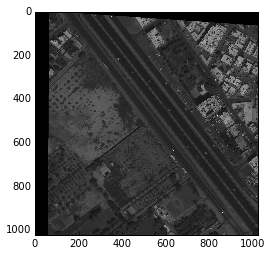

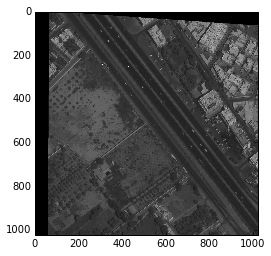

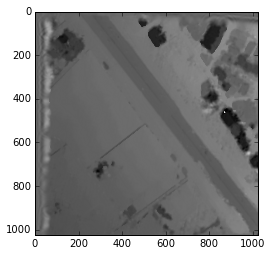

In [112]:
disp = get_heights(img0, img1)
imshow(img0)
imshow(img1)
imshow(disp)